In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotmap import DotMap
from pathlib import Path
from collections.abc import Mapping, Iterable

from IPython.display import display

%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Naming conventions

For easier reading, the following naming conventions are used. The templates are written as shell file template

+ `df_*` denotes an pandas.DataFrame
+ `dfs_*` denotes any dict-like mapping from names to pandas.DataFrame

Those naming conventions also holds for helper function signatures

# Config

In [3]:
DATA = Path("./data")

# Load Standards

Flags provide additional info on how the values in datasets where obtained

In [4]:
df_flags = pd.read_csv(
    DATA / "definitions_and_standards/flags.csv",
    keep_default_na=False,
    index_col="Flag"
)

The same country code are used in all of FAOSTAT datasets. As datasets contains aggregated data on country groups, loading that dataframe will allow to remove aggregated data.

In [5]:
df_area_groups = pd.read_csv(
    DATA / "definitions_and_standards/country_group.csv"
)

# Load datas

## Helper Functions

In [6]:
# Helper function
from src.utils import *

#snake case conversion
_first_cap_re = re.compile("(\w)([A-Z][a-z]+)")
_all_cap_re = re.compile("([a-z0-9])([A-Z])")
_space_between = re.compile("(\W*) ([a-z]*)")


def to_snakecase(name):
    s1 = _first_cap_re.sub(r"\1_\2", name)
    s2 = _all_cap_re.sub(r"\1_\2", s1).lower()
    s3 = _space_between.sub(r"\1_\2", s2)
    return s3.replace(" ", "").replace("__", "_")

def join_flags(df, filepath, df_flags):
    df["Flag"] = pd.read_csv(filepath, encoding="latin1", usecols=["Flag"], keep_default_na=False)
    return df.merge(df_flags, on="Flag").drop(columns="Flag").rename(columns={"Flags": "Flag"})

def split_on(df, column, rename={}, only_named=False, drop=[]):
    """
    Splits a dataframe in multiple dataframe based on the value of a columne
    
    Args:
        df: dataframe to spli
        column: name of the column to split on
        rename (optional): mapping or callable that rename values to name in the final dictionary
        only_named (False): keep only dataframe with a value in column that is renamed
        drop: drop columns in resulting dataframes (useful for redundant columns)
    
    Returns:
        A dictionnary mapping unique values in df[column] to the dataframe with that value.
        Value (i.e. dict keys) can be renamed by the rename argument. A callable can return None to not rename it.
    """
    result = DotMap(_dynamic=False)
    if not isinstance(drop, Iterable) or isinstance(drop, str):
        drop = [drop]
    for value in df[column].unique():
        if callable(rename):
            name = rename(value)
        elif isinstance(rename, Mapping):
            name = rename.get(value)
        else:
            name = None
        if name is None and only_named:
            continue
        result[name or value] = df[ df[column] == value].drop(columns=drop + [column])
    return result

## Animal emissions data

## Computed emissions data

In [7]:
# load base info, drop redundant year code column
df_env_emission_intensity = pd.read_csv(
    DATA / "global-food-agriculture-statistics/raw_files/Environment_Emissions_intensities_E_All_Data_(Normalized).csv",
    encoding="latin1",
).drop("Year Code", axis="columns")

# reload the flags to rpevent NaN collison on flags "" and "NA", and replace by their meaning
df_env_emission_intensity = join_flags(
    df_env_emission_intensity,
    DATA / "global-food-agriculture-statistics/raw_files/Environment_Emissions_intensities_E_All_Data_(Normalized).csv",
    df_flags
)

#Remove aggreagated data
df_env_emission_intensity = remove_country_group(df_env_emission_intensity, df_area_groups)

# Split on the Element column
dfs_env_em_intensity = split_on(
    df_env_emission_intensity, "Element",
    drop="Element Code",
    rename=to_snakecase
)
del df_env_emission_intensity
    
for table_name, df in dfs_env_em_intensity.items():
    print(f"\n\nTable {table_name}")
    print(f"  - Units: {', '.join(df['Unit'].unique())}")
    if table_name == "emissions_intensity":
        print("  - Available products:", end="\n      ")
        for k, prod in enumerate(df['Item'].unique()):
            print("%-23s" % prod, end="\n      " if k % 3 == 2 else "\t\t")
        print()
    print("  - Sample of 10 values:")
    display(df.sample(10))



Table emissions_intensity
  - Units: kg CO2eq/kg product
  - Available products:
      Cereals excluding rice 		Rice, paddy            		Meat, cattle           
      Milk, whole fresh cow  		Meat, goat             		Milk, whole fresh goat 
      Meat, sheep            		Milk, whole fresh sheep		Milk, whole fresh camel
      Meat, chicken          		Eggs, hen, in shell    		Milk, whole fresh buffalo
      Meat, pig              		Meat, buffalo          		
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
138970,162,Norway,1718,Cereals excluding rice,1973,kg CO2eq/kg product,0.2612,Calculated data
73422,79,Germany,1017,"Meat, goat",1995,kg CO2eq/kg product,68.5569,Calculated data
127360,28,Myanmar,947,"Meat, buffalo",2011,kg CO2eq/kg product,101.0285,Calculated data
41623,41,"China, mainland",1035,"Meat, pig",2005,kg CO2eq/kg product,1.1366,Calculated data
124834,143,Morocco,1130,"Milk, whole fresh camel",1964,kg CO2eq/kg product,6.3133,Calculated data
141621,164,Pacific Islands Trust Territory,867,"Meat, cattle",1979,kg CO2eq/kg product,63.2534,Calculated data
143685,166,Panama,882,"Milk, whole fresh cow",1978,kg CO2eq/kg product,2.1095,Calculated data
34879,37,Central African Republic,867,"Meat, cattle",2008,kg CO2eq/kg product,48.3579,Calculated data
187047,219,Tonga,1035,"Meat, pig",1986,kg CO2eq/kg product,24.7537,Calculated data
195395,215,United Republic of Tanzania,1017,"Meat, goat",1963,kg CO2eq/kg product,56.6269,Calculated data




Table emissions_(co2eq)
  - Units: gigagrams
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
143204,165,Pakistan,1058,"Meat, chicken",1983,gigagrams,105.5785,Calculated data
193594,225,United Arab Emirates,1020,"Milk, whole fresh goat",2002,gigagrams,145.6063,Calculated data
51658,167,Czechia,1058,"Meat, chicken",2001,gigagrams,7.2034,Calculated data
148325,171,Philippines,977,"Meat, sheep",2000,gigagrams,5.9079,Calculated data
177083,207,Suriname,1058,"Meat, chicken",2002,gigagrams,15.0374,Calculated data
132537,151,Netherlands Antilles (former),1058,"Meat, chicken",1975,gigagrams,0.1253,Calculated data
61108,60,El Salvador,867,"Meat, cattle",1967,gigagrams,1649.0946,Calculated data
98610,110,Japan,882,"Milk, whole fresh cow",1974,gigagrams,2569.7310,Calculated data
99706,112,Jordan,1020,"Milk, whole fresh goat",1990,gigagrams,34.2339,Calculated data
39121,96,"China, Hong Kong SAR",27,"Rice, paddy",1968,gigagrams,40.4303,Calculated data




Table production
  - Units: tonnes
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
343177,51,Czechoslovakia,977,"Meat, sheep",1972,tonnes,6040.0,Unofficial figure
330354,35,Cabo Verde,1062,"Eggs, hen, in shell",1976,tonnes,65.0,FAO estimate
235623,116,Democratic People's Republic of Korea,1718,Cereals excluding rice,1969,tonnes,2035000.0,"Aggregate, may include official, semi-official..."
232395,52,Azerbaijan,1718,Cereals excluding rice,1996,tonnes,991455.0,"Aggregate, may include official, semi-official..."
342272,13,Bahrain,1062,"Eggs, hen, in shell",1984,tonnes,3348.0,Unofficial figure
233062,233,Burkina Faso,1718,Cereals excluding rice,1969,tonnes,997973.0,"Aggregate, may include official, semi-official..."
240502,195,Senegal,1718,Cereals excluding rice,1971,tonnes,625403.0,"Aggregate, may include official, semi-official..."
335858,134,Malta,1017,"Meat, goat",1993,tonnes,15.0,FAO estimate
145212,168,Papua New Guinea,1062,"Eggs, hen, in shell",1985,tonnes,2430.0,Calculated data
236810,89,Guatemala,1718,Cereals excluding rice,1970,tonnes,867708.0,"Aggregate, may include official, semi-official..."


[]

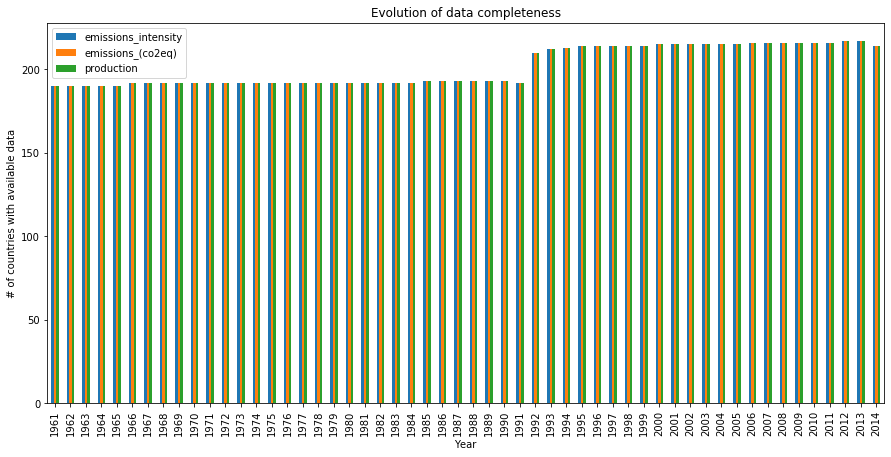

In [8]:
plot_completeness_histogram(dfs_env_em_intensity, figsize=(15, 7))
plt.plot()

The above histogram showing how complete the data are (number of country with data as a function of time) shows that the data are quite complete. Somme countries seems to have been added in 1992, let's find those.

In [9]:
df = dfs_env_em_intensity.production
df_before = df[ df["Year"] == 1991]
df_after = df[ df["Year"] == 1992]

set(df_after["Area"].unique()) - set(df_before["Area"].unique())

{'Armenia',
 'Azerbaijan',
 'Belarus',
 'Bosnia and Herzegovina',
 'Croatia',
 'Estonia',
 'Georgia',
 'Kazakhstan',
 'Kyrgyzstan',
 'Latvia',
 'Lithuania',
 'Republic of Moldova',
 'Russian Federation',
 'Serbia and Montenegro',
 'Slovenia',
 'Tajikistan',
 'The former Yugoslav Republic of Macedonia',
 'Turkmenistan',
 'Ukraine',
 'Uzbekistan'}

This is due to the dilution of the URSS. This will require special handling in the analysis and visualization: the choice of countries to use will most likely be done on a per year basis.

## Productions

In [10]:
# Load, remove duplicate column "year code"
df_prod_animals = pd.read_csv(
    DATA / "global-food-agriculture-statistics/raw_files/Production_LivestockPrimary_E_All_Data_(Normalized).csv",
    encoding="latin1"
).drop(columns="Year Code")

# Join the flag column with the standard meaning
df_prod_animals = join_flags(
    df_prod_animals,
    DATA / "global-food-agriculture-statistics/raw_files/Production_LivestockPrimary_E_All_Data_(Normalized).csv",
    df_flags
)

#remove aggregated data
df_prod_animals = remove_country_group(df_prod_animals, df_area_groups)

# Harmonise units
## 1000 Head -> Head
unit_filter = df_prod_animals["Unit"] == "1000 Head"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].multiply(1000)
df_prod_animals.loc[unit_filter, "Unit"] = "Head"

## 1000 No -> No
unit_filter = df_prod_animals["Unit"] == "1000 No"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].multiply(1000)
df_prod_animals.loc[unit_filter, "Unit"] = "No"

## 100mg/An 0.1g/An -> g/An
unit_filter = df_prod_animals["Unit"].isin(["100mg/An", "0.1g/An"])
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "g/An"

## hg/An -> kg/An
unit_filter = df_prod_animals["Unit"] == "hg/An"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "kg/An"

## hg -> kg
unit_filter = df_prod_animals["Unit"] == "hg"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "kg"

# Split according to Element column
dfs_prod_animals = split_on(
    df_prod_animals,
    "Element",
    rename=to_snakecase
)


for table_name, df in dfs_prod_animals.items():
    print(f"\n\nTable {table_name}")
    print(f"  - Units: {', '.join(df['Unit'].unique())}")
    print("  - Sample of 10 values:")
    display(df.sample(10))



Table laying
  - Units: Head
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
118250,196,Seychelles,1091,"Eggs, other bird, in shell",5313,2011,Head,2000.0,FAO estimate
855534,112,Jordan,1783,Eggs Primary,5313,1995,Head,5049000.0,"Aggregate, may include official, semi-official..."
918728,223,Turkey,1783,Eggs Primary,5313,2011,Head,78957000.0,"Aggregate, may include official, semi-official..."
155118,255,Belgium,1062,"Eggs, hen, in shell",5313,2004,Head,10367000.0,Official data
36132,50,Cyprus,1062,"Eggs, hen, in shell",5313,1962,Head,367000.0,FAO estimate
118934,197,Sierra Leone,1062,"Eggs, hen, in shell",5313,2009,Head,4300000.0,FAO estimate
839605,84,Greece,1783,Eggs Primary,5313,1986,Head,17000000.0,"Aggregate, may include official, semi-official..."
920916,230,Ukraine,1783,Eggs Primary,5313,2013,Head,103520000.0,"Aggregate, may include official, semi-official..."
82338,133,Mali,1062,"Eggs, hen, in shell",5313,1974,Head,3700000.0,FAO estimate
736839,88,Guam,1062,"Eggs, hen, in shell",5313,2010,Head,87000.0,FAO data based on imputation methodology




Table production
  - Units: tonnes, No, Head
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
193580,101,Indonesia,1058,"Meat, chicken",5510,2000,tonnes,803950.0,Official data
806311,39,Chad,1775,"Meat indigenous, poultry",5510,2010,tonnes,5250.0,"Aggregate, may include official, semi-official..."
328474,128,"China, Macao SAR",1058,"Meat, chicken",5510,1970,tonnes,1841.0,Calculated data
881165,159,Nigeria,1775,"Meat indigenous, poultry",5323,1969,Head,59364000.0,"Aggregate, may include official, semi-official..."
87488,138,Mexico,1141,"Meat, rabbit",5510,2001,tonnes,4190.0,FAO estimate
93744,149,Nepal,972,"Meat indigenous, buffalo",5322,1982,Head,345500.0,FAO estimate
203269,113,Kyrgyzstan,1017,"Meat, goat",5510,2004,tonnes,7073.0,Official data
72505,114,Kenya,1137,"Meat indigenous, camel",5322,1966,Head,30800.0,FAO estimate
548551,193,Sao Tome and Principe,1080,"Meat, turkey",5510,1986,tonnes,6.0,Calculated data
786382,9,Argentina,1806,Beef and Buffalo Meat,5510,1982,tonnes,2550542.0,"Aggregate, may include official, semi-official..."




Table producing_animals/slaughtered
  - Units: Head
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
846749,95,Honduras,1808,"Meat, Poultry",5321,1979,Head,8790000.0,"Aggregate, may include official, semi-official..."
15478,19,Bolivia (Plurinational State of),1080,"Meat, turkey",5321,1970,Head,109000.0,FAO estimate
40397,55,Dominica,977,"Meat, sheep",5320,1987,Head,1480.0,FAO estimate
273239,10,Australia,999,"Skins, sheep, with wool",5320,1968,Head,148805.0,Calculated data
735575,81,Ghana,1017,"Meat, goat",5320,2000,Head,769000.0,FAO data based on imputation methodology
903464,197,Sierra Leone,1807,Sheep and Goat Meat,5320,2014,Head,409619.0,"Aggregate, may include official, semi-official..."
827156,58,Ecuador,1806,Beef and Buffalo Meat,5320,1970,Head,441000.0,"Aggregate, may include official, semi-official..."
57482,88,Guam,1035,"Meat, pig",5320,1976,Head,6000.0,FAO estimate
378939,68,France,1058,"Meat, chicken",5321,2008,Head,818883000.0,Calculated data
740656,105,Israel,1058,"Meat, chicken",5321,2012,Head,426900000.0,FAO data based on imputation methodology




Table milk_animals
  - Units: Head
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
712619,299,Occupied Palestinian Territory,882,"Milk, whole fresh cow",5318,1998,Head,17640.0,Unofficial figure
772975,73,Georgia,951,"Milk, whole fresh buffalo",5318,2004,Head,NaN,Data not available
62300,93,Haiti,1020,"Milk, whole fresh goat",5318,2012,Head,705000.0,FAO estimate
161304,27,Bulgaria,982,"Milk, whole fresh sheep",5318,1963,Head,6617378.0,Official data
58958,90,Guinea,1020,"Milk, whole fresh goat",5318,1965,Head,70000.0,FAO estimate
53878,81,Ghana,882,"Milk, whole fresh cow",5318,1976,Head,124000.0,FAO estimate
58902,90,Guinea,882,"Milk, whole fresh cow",5318,1970,Head,163000.0,FAO estimate
176451,56,Dominican Republic,882,"Milk, whole fresh cow",5318,1998,Head,238981.0,Official data
90108,143,Morocco,882,"Milk, whole fresh cow",5318,1982,Head,1250000.0,FAO estimate
165101,40,Chile,882,"Milk, whole fresh cow",5318,1988,Head,640000.0,Official data




Table prod_popultn
  - Units: Head, No
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
42220,58,Ecuador,987,"Wool, greasy",5319,2008,Head,1860000.0,FAO estimate
228492,117,Republic of Korea,1182,"Honey, natural",5314,1973,No,105271.0,Official data
778963,174,Portugal,1182,"Honey, natural",5314,1988,No,NaN,Data not available
774912,119,Latvia,1182,"Honey, natural",5314,2010,No,NaN,Data not available
163898,33,Canada,987,"Wool, greasy",5319,1978,Head,306400.0,Official data
771810,59,Egypt,1182,"Honey, natural",5314,1963,No,NaN,Data not available
188997,90,Guinea,1182,"Honey, natural",5314,2008,No,0.0,Official data
775342,129,Madagascar,1182,"Honey, natural",5314,1994,No,NaN,Data not available
775356,129,Madagascar,1182,"Honey, natural",5314,2008,No,NaN,Data not available
222440,169,Paraguay,987,"Wool, greasy",5319,1986,Head,388152.0,Official data




Table yield
  - Units: g/An, kg/An, kg
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
511640,165,Pakistan,1025,"Skins, goat, fresh",5420,2009,kg/An,4.3,Calculated data
578088,210,Sweden,999,"Skins, sheep, with wool",5420,1963,kg/An,900.0,Calculated data
560894,199,Slovakia,995,"Skins, sheep, fresh",5420,1997,kg/An,1.3,Calculated data
465266,134,Malta,1020,"Milk, whole fresh goat",5420,2003,kg/An,427.0,Calculated data
381983,70,French Polynesia,919,"Hides, cattle, fresh",5420,1984,kg/An,24.3,Calculated data
465636,134,Malta,1780,"Milk,Total",5420,1997,kg/An,1994.2,Calculated data
511578,165,Pakistan,982,"Milk, whole fresh sheep",5420,2002,kg/An,44.8,Calculated data
604149,225,United Arab Emirates,1130,"Milk, whole fresh camel",5420,1983,kg/An,245.7,Calculated data
489995,149,Nepal,1783,Eggs Primary,5410,1967,g/An,4000.0,Calculated data
300446,21,Brazil,987,"Wool, greasy",5422,1997,kg,1.0,Calculated data




Table yield/carcass_weight
  - Units: kg/An, g/An
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
451716,124,Libya,1012,"Meat indigenous, sheep",5417,1976,kg/An,15.9,Calculated data
379154,68,France,1073,"Meat, goose and guinea fowl",5424,1979,g/An,5305.8,Calculated data
603614,225,United Arab Emirates,1012,"Meat indigenous, sheep",5417,1969,kg/An,18.0,Calculated data
367815,60,El Salvador,977,"Meat, sheep",5417,1991,kg/An,15.0,Calculated data
602687,230,Ukraine,977,"Meat, sheep",5417,1996,kg/An,12.3,Calculated data
456198,129,Madagascar,1141,"Meat, rabbit",5424,2011,g/An,1200.0,Calculated data
355780,54,Denmark,1055,"Meat indigenous, pig",5417,1985,kg/An,71.3,Calculated data
494508,153,New Caledonia,867,"Meat, cattle",5417,1998,kg/An,179.3,Calculated data
347148,50,Cyprus,944,"Meat indigenous, cattle",5417,1982,kg/An,302.0,Calculated data
536437,183,Romania,977,"Meat, sheep",5417,2001,kg/An,10.6,Calculated data


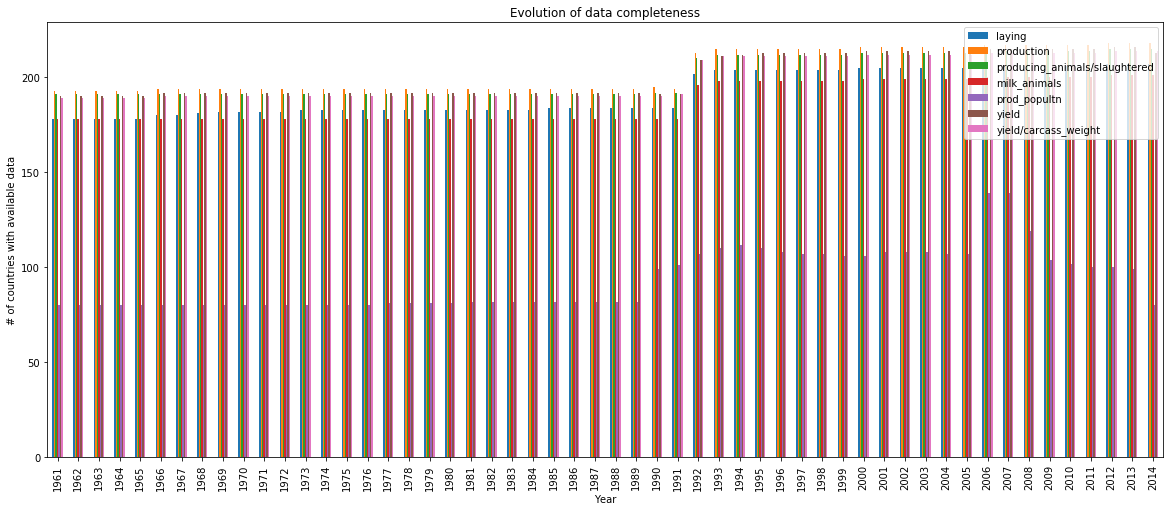

In [11]:
plot_completeness_histogram(dfs_prod_animals, figsize=(20,8))

The above bar plot shows that the `prod_popultn` Table has a lot of missing countries. Given the data it holds, namely the production of `['Wool, greasy', 'Honey, natural', 'Beeswax', 'Silk-worm cocoons, reelable', 'Hair, horse']`, this is not a problem.

The tables we are mostly interested in are `production`, `yield` and `producing_animals/slaughtered`, so we will have to consider only contries at least in those three tables.

## Trade data

# Livestock food estimate

Using [http://www.agronext.iastate.edu/immag/pubs/manure-prod-char-d384-2.pdf](http://www.agronext.iastate.edu/immag/pubs/manure-prod-char-d384-2.pdf), we can try to estimate the food consuption of some livestock

## Beef

Using the above reference, section 4 for the equations, Table 2 for variable definitons, and Tables 3a and 3b for assumption, we get:

$$
\begin{align}
    \mathit{DM} &= \sum_{ration} \left(
                    \mathit{DMI}_\mathit{ration}
                    \times \mathit{DOF}_\mathit{ration}
                    \times \left(1 - \frac{\mathit{DMD}_\mathit{ration}}{100}\right)
                   \right)
                    +
                   \sum_{ration} \left(
                    \mathit{DOF}_\mathit{ration}
                    \times 20.3 \times 0.06
                    \times \mathit{BW}_\mathit{AVG}
                  \right)
\end{align}
$$
where:
+ $\mathit{DM}$: total dry matter excretion
+ $\mathit{DMI}$: Dry Matter Ingestion, for a given ration
+ $\mathit{DOF}$: Day On Feed, number of days a ration lasts
+ $\mathit{DMD}$: Dry Matter Digestibility
+ $\mathit{BW}_\mathit{AVG}$: Body Weight average for the duration of the ration

Given the second part handles the dry content of urine (6%) and since the average body weigth is 471kg, the factor 20.3 is highly dubious - a cattle does not excrete 20 times its mass in urine a day.

After research, we found cattle produce a bit more than 20L gallons a day of urine, and $\frac{471~\mathit{kg}}{20.3 ~ \mathit{kg} . L^{-1}} = 23.2~L$. We therefore correct the above equation to *divide* the body weigth by 20.3.

We first formally split all multi-days ration into 1 day rations, so that $\mathit{DOF} := 1$. Then with Table 3b we estimate the dry matter digestibility to be 80%, hence $\mathit{DMD} = 80$ in the equation. Finally, from Table 3b, $\mathit{DMI} = 0.02 \mathit{BW}_\mathit{AVG}$.

We get:

$$
\begin{align}
    \mathit{DM} &= \sum_{ration} \left(
                    0.2 \times 0.02 \times \mathit{BW}_\mathit{AVG}
                    +
                    \frac{0.06}{20.3} \mathit{BW}_\mathit{AVG}
                  \right) \\
    \mathit{DM} &= 6.956 \times 10^{-3} \times \sum_{ration} \mathit{BW}_\mathit{AVG} \\
    \sum_\mathit{ration} \mathit{BW}_\mathit{AVG} &= 3.383 \times 10^2 \times \mathit{DM}
\end{align}
$$

Injecting the relationship between $\mathit{DM}$ and $\mathit{BW}$, we get:

$$
\begin{align}
    \sum_{ration} \mathit{DMI} &= 0.02 \times \sum_{ration} \mathit{BW}_\mathit{AVG} \\
    \sum_{ration} \mathit{DMI} &= 6.7667 \times \mathit{DM}
\end{align}
$$

This holds for the whole life of the cattle. Inputing the water content of 92% for manure, we finally get (keeping more precision digit from previous calculations):

$$
    \sum_{ration} \mathit{DMI} = 0.54133 \times \mathit{Manure}
$$

In [15]:
def cattle_consumption_from_manure(manure):
    """
    Yield the food consumption in kg of dry matter of non-dairy cattle
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return manure * 0.54133

## Dairy cattle

The above reference, section 5 yields:
$$
    \mathit{DM}_\mathit{per~day} = 0.350 \times \mathit{DMI} + 1.017
$$

Including the milk production is a bit more precise according to the reference, but requires estimating the content of true protein on our end:

$$
    \mathit{DM}_\mathit{per~day} =
        0.135 \times \mathit{Milk}
        + 0.004 \times \mathit{BW}
        + 0.004 \times \mathit{DIM}
        + 118.370 \times \mathit{MTP}
        - 2.456
$$

where:
+ $\mathit{MTP}$ is the Milk True Protein in g / g of milk / day

The average body weigth is from the same document 624kg. The moisture content of manure is reported to be 87%.

In [ ]:
# Whenever possible, constant and estimated values have been aggregated
def dairy_cattle_consumption_from_manure(manure, days=365.25):
    """
    Yields the food consumption in kg of dry matter of dairy cattle
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return ((0.13 * manure) - 1.017 * days) / 0.35

def dairy_cattle_consumption_from_manure_milk(manure, milk, milk_true_prot, days=365.25):
    """
    Yields the food consumption in kg of dry matter of non-dairy cattle
    from their production of manure and milk
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return (0.17 * manure - 0.135 * milk - 118.370 * milk_true_prot - 0.004 * days) / 0.004

## Poultry
This includes Broilers, Turkeys and ducks. The conversion from section 7 is strait-forward

In [16]:
def broiler_consumption_from_manure(manure):
    """
    Yields the food consumption in kg of dry matter of broiler
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return manure * 0.3116

def turkey_consumption_from_manure(manure):
    """
    Yields the food consumption in kg of dry matter of turkey, Toms and Hens
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return manure * 0.2521

def duck_consumption_from_manure(manure):
    """
    Yields the food consumption in kg of dry matter of duck
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return manure * 0.3063

## Poultry (laying hen)

Using the equation from 8.3.1 and injecting all the estimates from Table 11, we get a simple affine function. Manure is estimated as 75% moisture

In [17]:
def laying_consumption_from_manure(manure, days=365.25):
    """
    Yields the yearly food consumption in kg of dry matter of laying hen
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return (manure / 4 + 16.3295 * days) / 0.3509

## Swine

We differenciate between nursery pig (5 - 20kg) and grow-finishing pig (20 - 120 kg).
Using section 9.3.1, we get:

$$
    \mathit{DM} = \mathit{DMI} * \frac{100 - DMD}{10000}
                    + 0.025 \times \mathit{DOF} \times \left(
                        20 \mathit{BW}_\mathit{AVG} + 2100
                      \right)
$$

Inputing the assumptions from Table 18b:
+ $\mathit{DMD} = 82$
+ $\mathit{DOF} = 120$
+ $\mathit{DMI} = 0.034 \mathit{BW}$

Solving first for $\mathit{BW}$ and then going back to $\mathit{DMI}$, we get:

$$
    \mathit{DMI} = 0.034 \times \frac{\mathit{DM} - 6300}{60}
$$

For nursery swine, equation 9.4.1 with assumptions from Table 18b yields simply:

$$
    \mathit{DMI} = \frac{1000}{72} \mathit{DM}
$$

From Table 18a, we hestimate that the manure is $(120 - 56) / 120 = 53\%$ moisture

In [19]:
def swine_consumption_from_manure(manure, swine_count):
    """
    Yields the yearly food consumption in kg of dry matter of laying hen
    from their production of manure and the total number of swine
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return 0.034 * (manure * 56 / 120 - 6300 * swine_count) / 60

def nursery_swine_consumption_from_manure(manure):
    return 1000 / 72 